In [15]:
import re
import string
import nltk
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diwak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diwak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
data = pd.read_csv("integrated.csv")


In [18]:
data.head()

,comment_text,label
0,"""\nAre you aware that you wrote: """"When we hav...",0
1,""" If your section is not titled appropriately...",0
2,Thank you for experimenting with Wikipedia. Y...,0
3,"I was blocked but then he changed his mind, bu...",0
4,"John M Baker\nKyle's Father died in ~ 2003, so...",0


In [19]:
df = data.copy()

In [20]:
df.shape

(184354, 2)

In [49]:
label_counts = df['label'].value_counts()
print(label_counts)

label
0    143346
1     41008
Name: count, dtype: int64


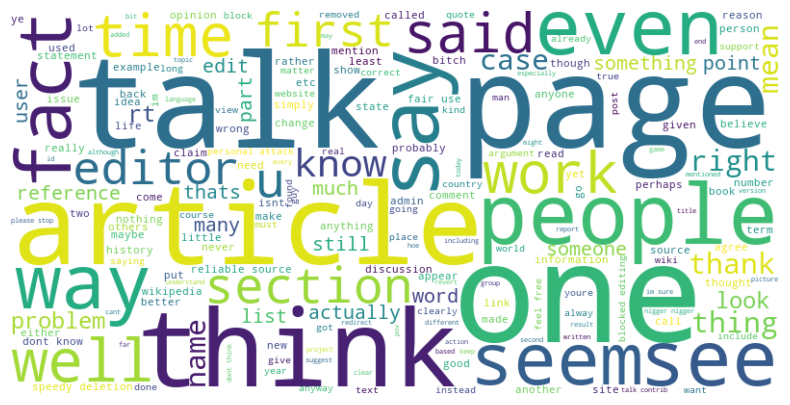

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text in the comment_text column
text = " ".join(comment for comment in df['comment_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [53]:
#MODELING

In [25]:
# Apply the cleaning function
df['comment_text'] = df['comment_text'].apply(clean)

# Tokenize the text
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df['comment_text'].values)
X = tokenizer.texts_to_sequences(df['comment_text'].values)
X = pad_sequences(X, maxlen=max_len)

# Prepare target variable
Y = df['label'].values

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

C:\Users\diwak\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 251s 119ms/step - accuracy: 0.9198 - loss: 0.2166 - val_accuracy: 0.9557 - val_loss: 0.1258
Epoch 2/5
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 232s 112ms/step - accuracy: 0.9567 - loss: 0.1198 - val_accuracy: 0.9553 - val_loss: 0.1242
Epoch 3/5
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 650s 314ms/step - accuracy: 0.9583 - loss: 0.1113 - val_accuracy: 0.9546 - val_loss: 0.1240
Epoch 4/5
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 244s 117ms/step - accuracy: 0.9621 - loss: 0.0998 - val_accuracy: 0.9561 - val_loss: 0.1309
Epoch 5/5
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 250s 120ms/step - accuracy: 0.9650 - loss: 0.0904 - val_accuracy: 0.9530 - val_loss: 0.1338


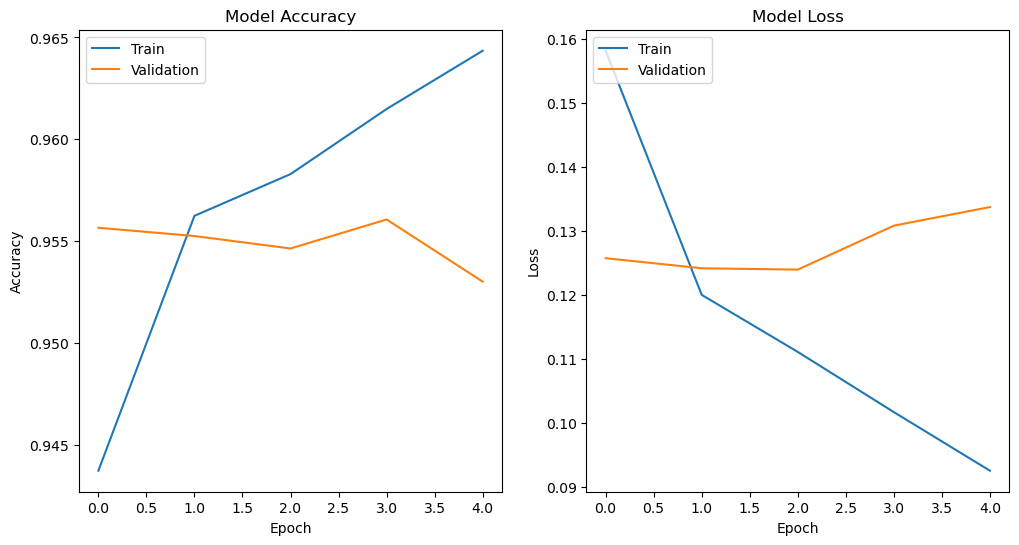

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


1153/1153 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step
Accuracy: 0.9530796560982886
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     28650
           1       0.93      0.85      0.89      8221

    accuracy                           0.95     36871
   macro avg       0.95      0.92      0.93     36871
weighted avg       0.95      0.95      0.95     36871



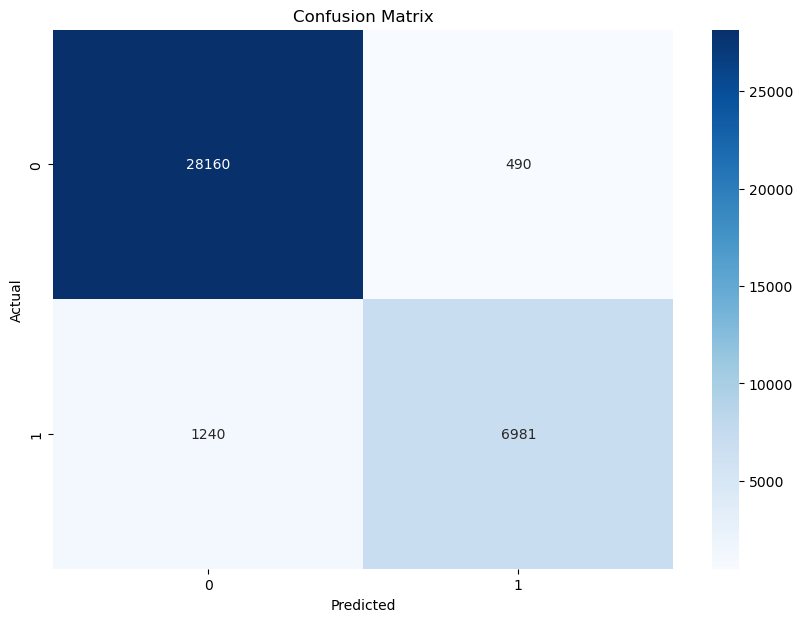

In [35]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

Y_pred = (model.predict(X_test) > 0.5).astype("int32")

print('Accuracy: {}'.format(accuracy_score(Y_test, Y_pred)))
print(classification_report(Y_test, Y_pred))

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [36]:
def predict_sentiment(comment_text):
    comment_text = clean(comment_text)
    seq = tokenizer.texts_to_sequences([comment_text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = (model.predict(padded) > 0.5).astype("int32")
    return pred[0][0]

# Example usage
print(predict_sentiment("You are really dumb"))
print(predict_sentiment("happy"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0


<Figure size 1000x600 with 0 Axes>

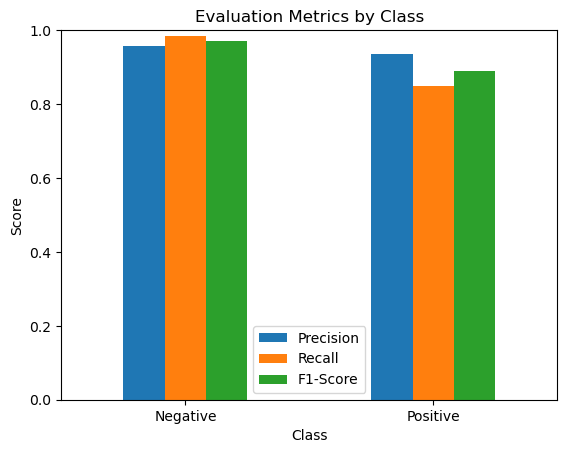

In [38]:
# Extracting the metrics for each class
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, support = precision_recall_fscore_support(Y_test, Y_pred, average=None)

# Creating a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Class': ['Negative', 'Positive'],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
})

# Plotting the bar graph
plt.figure(figsize=(10, 6))
metrics_df.set_index('Class').plot(kind='bar')
plt.title('Evaluation Metrics by Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()


In [54]:
with open('sentiment_analysis_model.pkl', 'wb') as f:
    pickle.dump({
        'model_architecture': model_json,
        'model_weights': "model/model_weights.h5"
    }, f)

print("Model architecture and weights saved in 'sentiment_analysis_model.pkl'.")

Model architecture and weights saved in 'sentiment_analysis_model.pkl'.
